In [5]:

import numpy as np
import matplotlib.pyplot as plt 
#from scipy.special import ellipk, ellipe, elliprf, elliprj 
from scipy.integrate import quad
from scipy.spatial.transform import Rotation 
import scipy.optimize
import pandas as pd
import sklearn
from scipy.interpolate import RBFInterpolator
from scipy.interpolate import LinearNDInterpolator 
 
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
import einops as eo
import joblib
import dill 
import time
from functools import partial

import sys





In [6]:
def ellipp(n, m):
    n, m = (np.asarray(x) for x in (n, m))
    if np.any(m >= 1):
        raise ValueError("m must be < 1")
    y = 1 - m
    rf = elliprf(0, y, 1)
    rj = elliprj(0, y, 1, 1 - n)
    return rf + rj * n / 3


def ellipc(kc, p, c, s):
    kc, p, c, s = (np.asarray(x, dtype = np.float64) for x in (kc, p, c, s))
    #print(p[p<=0])
    if np.any(kc==0):
        raise ValueError("kc cannot be 0.")
    errtol=1e-10
    k = np.abs(kc)

    pp = p.copy()
    cc = c.copy()
    ss = s.copy() 
    em = 1.
    cond = p>0 

    pp[cond] = np.sqrt(p[cond])
    ss[cond] = (s/pp)[cond]

    if np.any(~cond):
        f = kc[~cond]**2 
        q = 1 - f
        g = 1 - pp[~cond]
        f = f - pp[~cond]
        q = q*(ss[~cond]-c[~cond]*pp[~cond])
        pp[~cond] = np.sqrt(f/g)
        cc = (c[~cond]-ss[~cond])/g
        ss[~cond] = (-q/(pp[~cond]*g**2+cc*pp[~cond]))
    f = cc.copy()
    cc = cc + ss/pp
    g = k/pp
    ss = 2*(ss+f*g)
    pp = g + pp
    g = em
    em = k + em
    kk = k.copy()
    while(np.any(np.abs(g-k)>g*errtol)):
        k = 2*np.sqrt(kk)
        kk = k*em
        f = cc.copy()
        cc = cc + ss/pp
        g = kk/pp
        ss = 2*(ss+f*g)
        pp = g + pp
        g = em.copy()
        em = k + em
    return (np.pi/2)*(ss+cc*em)/(em*(em+pp))
        
def test_ellipc(n, k):
    m = k**2
    kc = np.sqrt(1-m)
    elliptic = np.array([ellipk(m), ellipe(m), ellipp(n, m)])
    arg1 = np.array([kc, kc, kc])
    arg2 = np.array([1, 1, -n+1])
    arg3 = np.array([1, 1, 1])
    arg4 = np.array([1, kc**2, 1])

    elliptic_results = ellipc(arg1, arg2, arg3, arg4)
    test_1 = np.allclose(elliptic, elliptic_results, 1e-7) 
    return test_1
    

def alpha(xi, rr, R):
    return R/(np.sqrt(xi**2 +(rr+R)**2 ))
def beta(xi, rr, R):
    return xi/(np.sqrt(xi**2 +(rr+R)**2 ))
def k(xi, rr, R):
    num = (xi**2 + (R-rr)**2)
    den = (xi**2 + (R+rr)**2)
    return np.sqrt(num/den)

def Br_func(rr, zz, R=0.03, L=0.02, C=1.4):
    Bmax = C
    M = (Bmax)*(np.sqrt(4*L**2 +R**2)/(2*L))

    xi_p, xi_m = zz+L, zz-L
    alpha_p, alpha_m = alpha(xi_p, rr, R), alpha(xi_m, rr, R)


    kp, km = k(xi_p, rr, R), k(xi_m, rr, R)

    Br = (M*R/np.pi)* (alpha_p*ellipc(kp, 1, 1, -1) - alpha_m*ellipc(km, 1, 1, -1))
    return Br

def Bz_polar_func(rr, zz, R=0.03, L=0.02, C=1.4):
    Bmax = C
    M = (Bmax)*(np.sqrt(4*L**2 +R**2)/(2*L))
    xi_p, xi_m = zz+L, zz-L
    beta_p, beta_m = beta(xi_p, rr, R), beta(xi_m, rr, R)
    gamma = (R-rr)/(R+rr)

    kp, km = k(xi_p, rr, R), k(xi_m, rr, R)

    Bz = (R*M/(np.pi*(rr+R))) * (beta_p*ellipc(kp, gamma**2, 1, gamma) - beta_m*ellipc(km, gamma**2, 1, gamma))
    return Bz


def Bxyz_func(xx, yy, zz, R=3, L=2, C=1e3):
    tt = np.arctan2(yy,xx)
    rr = np.sqrt(xx**2 + yy**2)
    Br = Br_func(rr, zz, R, L, C)
    Bx = Br * np.cos(tt)
    By = Br * np.sin(tt)
    Bz = Bz_polar_func(rr, zz, R, L, C)
    return Bx, By, Bz

#def Bx_func(xx, yy, zz, R=3, L=2, C=1e3):
#    tt = np.arctan2(yy,xx)
#    rr = np.sqrt(xx**2 + yy**2)
#    Br = Br_func(rr, zz, R, L, C)
#    Bx = Br * np.cos(tt)
#    return Bx

#def By_func(xx, yy, zz, R=3, L=2, C=1e3):
#    tt = np.arctan2(yy,xx)
#    rr = np.sqrt(xx**2 + yy**2)
#    Br = Br_func(rr, zz, R, L, C)
#    By = Br * np.sin(tt)
#    return By

#def Bz_func(xx, yy, zz, R=3, L=2, C=1e3):
#    rr = np.sqrt(xx**2 + yy**2)
#    Bz = Bz_polar_func(rr, zz, R, L, C)
#    return Bz

def Bx_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[0]

def By_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[1]

def Bz_func(xx, yy, zz, R=3, L=2, C=1e3):
    return Bxyz_func(xx, yy, zz, R, L, C)[2]

def Bx(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    Bx = Bx_func(xin, yin, zin, R, L, C)
    return Bx


def By(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    By = By_func(xin, yin, zin, R, L, C)
    return By

def Bz(X, x0, y0, z0, rx, ry, rz, R, L, C):
    rot_vec = np.array([rx, ry, rz])
    r = Rotation.from_rotvec(rot_vec)
    Xrot = r.apply(X.T).T
    x, y, z = Xrot
    xin, yin, zin = x-x0, y-y0, z-z0

    Bz = Bz_func(xin, yin, zin, R, L, C)
    return Bz


def Bx_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    Bx = Bx_func(xin, yin, zin, R, L, C)
    return Bx


def By_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    By = By_func(xin, yin, zin, R, L, C)
    return By

def Bz_no_rot(x0, y0, z0, R, L, X, C):
    x, y, z = X
    xin, yin, zin = x-x0, y-y0, z-z0

    Bz = Bz_func(xin, yin, zin, R, L, C)
    return Bz

0.017750342794404714


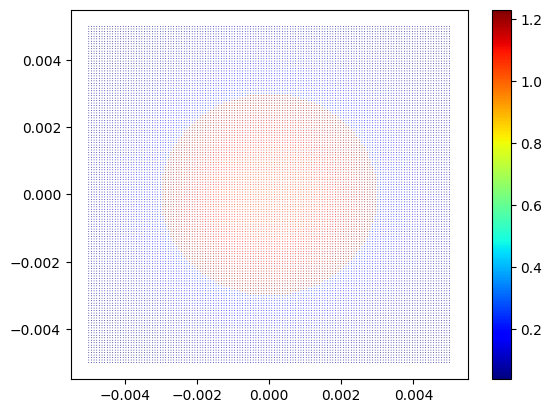

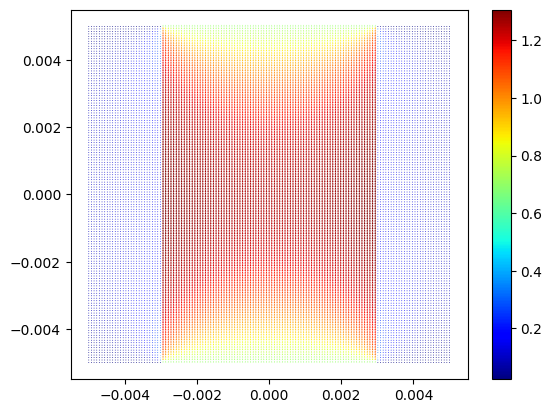

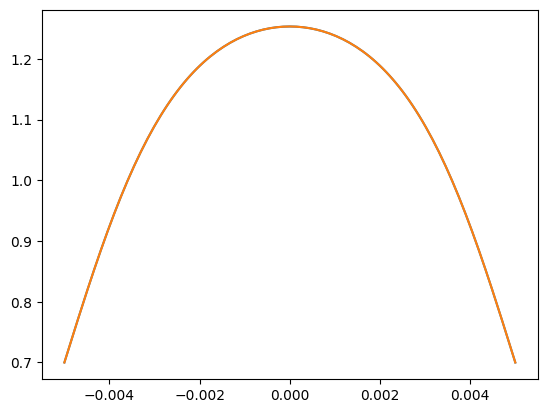

In [7]:

samples = 137
max = 0.005
#max = 10 
x = np.linspace(-max, max, samples)
y = np.linspace(-max, max, samples)
z = np.linspace(-max, max, samples)

xx, yy, zz = np.meshgrid(x, y, z)

# dimentions in mm
L = 0.001
C = 1.4
R = 0.003 

#L = 2 
#C = 1
#R = 3 

Bmax = C
M = (Bmax)*(np.sqrt(4*L**2 +R**2)/(2*L))

x_in = xx 
y_in = yy 
z_in = zz

Bx = Bx_func(x_in, y_in, z_in, R, L ,C)
By = By_func(x_in, y_in, z_in, R, L, C)
Bz = Bz_func(x_in, y_in, z_in, R, L, C)


Bnorm = np.sqrt(Bx**2+By**2+Bz**2)
Bxdir, Bydir, Bzdir = Bx/Bnorm, By/Bnorm, Bz/Bnorm
Blog = np.log10(Bnorm-Bnorm.min()+1)
Bxlog, Bylog, Bzlog = Bxdir*Blog, Bydir*Blog, Bzdir*Blog
print(Bnorm.min())


colormap='jet'
#plt.quiver(x, y, Mxlog, Mylog, Mnorm, cmap=colormap, norm = LogNorm(vmin = Mnorm.min(), vmax = Mnorm.max()))
#looks cool
#plt.quiver(x, y, Mxlog, Mylog, Mnorm, cmap=colormap, scale=50)

ind = samples//2 + samples//3 
#f = plt.figure()
#ax = f.add_subplot(111, polar=Tr)
if True:
    plt.quiver(xx[:,:,ind], yy[:,:,ind], Bxlog[:,:,ind], Bylog[:,:,ind], Bnorm[:,:,ind], cmap=colormap, scale = 10)
    #plt.quiver(tt[:,:,ind], rr[:,:,ind], Bxlog[:,:,ind], Bylog[:,:,ind], Bnorm[:,:,ind], cmap=colormap, scale = 100)
    plt.colorbar()
    plt.show()

    ind = samples//2 + 0 

    plt.quiver(yy[:,ind,:], zz[:,ind,:], Bylog[:,ind,:], Bzlog[:,ind,:], Bnorm[:,ind,:], cmap=colormap, scale = 50)
    plt.colorbar()
    plt.show()

ind = samples//2

Bz_axis = M/2 *( (z+L)/np.sqrt(((z+L)**2 + R**2)) - (z-L)/np.sqrt((z-L)**2+R**2) )
plt.plot(zz[ind, ind, :], Bz[ind, ind, :])
plt.plot(z, Bz_axis)
plt.show()